In [1]:
# Import libraries

# General libraries 
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle #shuffle array in consistant way
import shutil

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

# Work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv

# Model Development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# loading data

In [2]:
train = "D:\\PG-DBDA\\project\\train"
test='D:\\PG-DBDA\\project\\test'
df=pd.read_csv("D:\\PG-DBDA\\project\\train_labels.csv")
testing=pd.read_csv("D:\\PG-DBDA\\project\\sample_submission.csv")

In [3]:
# declare constants for reproduciblity
RANDOM_STATE = 49

In [4]:
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [5]:
# So, how many images are there in each of the folder in the training dataset?

print(len(os.listdir('D:\\PG-DBDA\\project\\train')))
print(len(os.listdir('D:\\PG-DBDA\\project\\test')))

220025
57458


In [6]:
df.describe(include='all')

,id,label
count,220025,220025.000000
unique,220025,NaN
top,f38a6374c348f90b587e046aac6079959adf3835,NaN
freq,1,NaN
mean,NaN,0.405031
std,NaN,0.490899
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


# Data visualization

[Text(0.5, 1.0, 'Label Counts Histogram')]

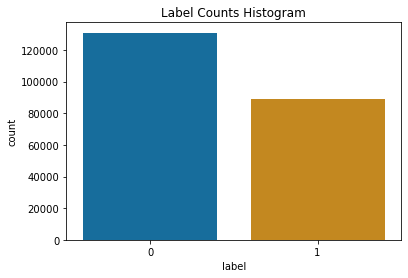

In [8]:
# create histogram


sns.countplot(x=df['label'], palette='colorblind').set(title='Label Counts Histogram')

In [104]:
#create pie chart

fig = px.pie(df, 
             values = df['label'].value_counts().values, 
             names = df['label'].unique())
fig.update_layout(
    title={
        'text': "Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [10]:
import os
base_dir = 'D:\\PG-DBDA\\project\\'
print(os.listdir(base_dir))

['Presentation1.pptx', 'sample_submission.csv', 'test', 'train', 'train.zip', 'train_labels.csv']


In [11]:
from PIL import Image

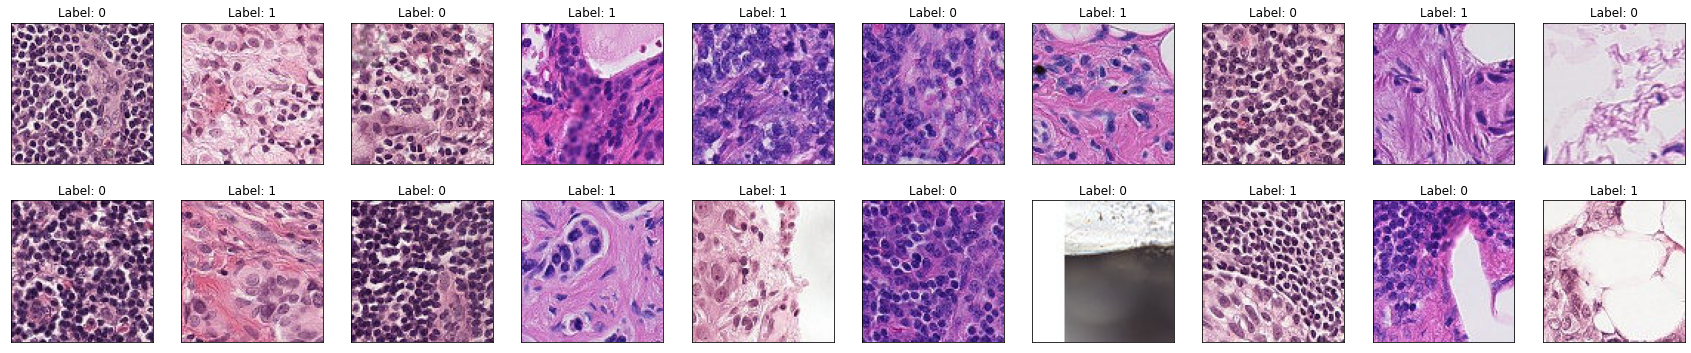

In [12]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = df.loc[df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

In [13]:
# set model constants

BATCH_SIZE = 256

In [14]:
# prepare data for training
def append_tif(string):
    return string+".tif"

df["id"] = df["id"].apply(append_tif)
df['label'] = df['label'].astype(str)

# randomly shuffle training data
df = shuffle(df, random_state=RANDOM_STATE)

# Normalization

In [15]:
# modify training data by normalizing it and split data into training and validation sets

datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

# Data Generation

In [16]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))        # original image = (96, 96) 

Found 187022 validated image filenames belonging to 2 classes.


In [17]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))       # original image = (96, 96) 

Found 33003 validated image filenames belonging to 2 classes.


In [18]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

# Model build

In [19]:
# set ROC AUC as metric
# Implementation with keras
ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (64, 64, 3))) # original image = (96, 96, 3) 
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 64)        18496     
                                                        

In [20]:
#compile
adam_optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1], optimizer=adam_optimizer)

In [35]:
# Get the labels that are associated with each index
print(valid_generator.class_indices)

{'0': 0, '1': 1}


# fit the model

In [21]:
EPOCHS = 3

# train the model
history_model = model.fit(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/3
731/731 [==============================] - 16249s 22s/step - loss: 0.4915 - accuracy: 0.7645 - auc: 0.8341 - val_loss: 0.4474 - val_accuracy: 0.7968 - val_auc: 0.8673
Epoch 2/3
731/731 [==============================] - 15872s 22s/step - loss: 0.4336 - accuracy: 0.8044 - auc: 0.8742 - val_loss: 0.4052 - val_accuracy: 0.8186 - val_auc: 0.8932
Epoch 3/3
731/731 [==============================] - 17682s 24s/step - loss: 0.4028 - accuracy: 0.8223 - auc: 0.8924 - val_loss: 0.3759 - val_accuracy: 0.8362 - val_auc: 0.9083


In [22]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy', 'auc']

# Evaluate the model

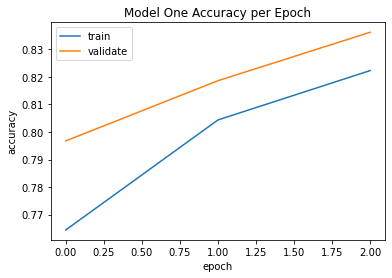

In [23]:
# plot model accuracy per epoch 
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

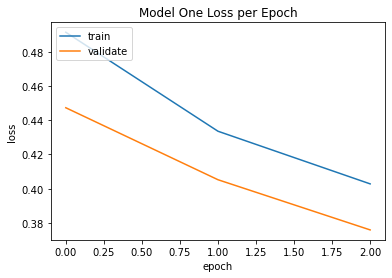

In [24]:
# plot model loss per epoch
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

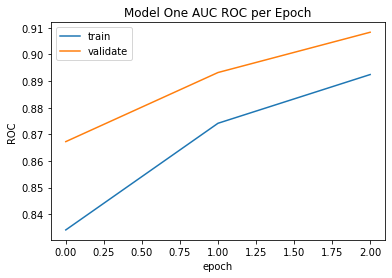

In [25]:
# plot model ROC per epoch
plt.plot(history_model.history['auc'])
plt.plot(history_model.history['val_auc'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# Test final model against the test set

In [26]:
#double check what you're aiming the submission data set to look like
testing.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [27]:
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test)})
test_df.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [122]:
# prepare test data (in same way as train data)
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test,
    x_col='id', 
    y_col=None,
    
    target_size=(64,64),         # original image = (96, 96) 
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [92]:
#run model to find predictions


predictions = model.predict(test_generator, verbose=1)

57458/57458 [==============================] - 2440s 42ms/step


In [94]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

57458

In [95]:
predictions.shape

(57458, 1)

In [77]:
#create testing dataframe
predictions = np.transpose(predictions)[0]
testing_df = pd.DataFrame()
testing_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
testing_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
testing_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [78]:
#view test detection counts
testing_df['label'].value_counts()

0    35437
1    22021
Name: label, dtype: int64

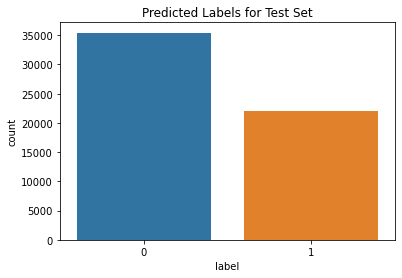

In [79]:
#plot test detection
sns.countplot(data=submission_df, x='label').set(title='Predicted Labels for Test Set');

In [102]:
#convert to csv 
testing_df.to_csv('test.csv', index=False)